In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
from scipy.optimize import brute
import calendar
from datetime import datetime, timedelta, date
import pytz
from yahoo_fin import stock_info as si
from yahoo_fin import news
import statsmodels.api as sm
import ssl
import requests
import notion
import plotly.io as pio
import plotly.graph_objects as go
from abc import ABC, abstractmethod
from tqdm import tqdm
ssl._create_default_https_context = ssl._create_unverified_context
pio.renderers.default = "notebook"
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 1000)
sns.set()
# http://theautomatic.net/yahoo_fin-documentation/#get_quote_data
# https://www.bitstamp.net/api/#ticker
# https://medium.com/coinmonks/sourcing-intra-day-crypto-data-c804ea199baf
# https://www.cryptodatadownload.com/data/bitstamp/

In [3]:
# si.get_top_crypto().head(10)

In [4]:
def convert_UTC_to_Central(t, formating=""):
    from_zone = pytz.timezone("UTC")
    to_zone = pytz.timezone("America/Chicago")
    
    if type(t)==str:
        utc = datetime.strptime(t, formating)
    else:
        utc = t
    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)
    # Convert the time zone
    cst = utc.astimezone(to_zone)
    return cst

In [5]:
def compute_pnl(transactions, asset):
    sub = transactions[transactions["Asset"] == asset]
    ticker = asset+"-USD"
    prev_price, unit, pnl = 0, 0, 0
    for idx, row in sub.iterrows():
        price = row["Spot Price at Transaction"]
        pnl += unit * (price-prev_price)
        if row["Transaction Type"] == "Buy": 
            unit += row["Quantity Transacted"]
        else:
            unit -= row["Quantity Transacted"]
        prev_price = price
    price_now = si.get_live_price(ticker)
    pnl += unit*(price_now-prev_price)
    return pnl

In [6]:
raw = pd.read_excel("CoinbaseTransactions.xlsx")
transactions = raw.iloc[8:]
transactions.columns = raw.iloc[7].values
new_index = [convert_UTC_to_Central(t, "%Y-%m-%dT%H:%M:%SZ") for t in transactions["Timestamp"]]
transactions.index = new_index
transactions = transactions.drop(columns="Timestamp")
transactions

,Transaction Type,Asset,Quantity Transacted,Spot Price Currency,Spot Price at Transaction,Subtotal,Total (inclusive of fees),Fees,Notes
2022-01-05 21:03:39-06:00,Buy,BTC,0.108677,USD,43519.14,4729.53,4800,70.47,"Bought 0.108677 BTC for $4,800.00 USD"
2022-01-06 09:24:25-06:00,Buy,BTC,0.000234,USD,42835.27,10,10,0,Bought 0.00023352 BTC for $10.00 USD
2022-01-07 10:00:54-06:00,Buy,ETH,0.312264,USD,3155.41,985.32,1000,14.68,"Bought 0.31226371 ETH for $1,000.00 USD"
2022-01-07 18:20:58-06:00,Buy,SOL,2.287172,USD,137.86,315.3,320,4.7,Bought 2.28717171 SOL for $320.00 USD


In [7]:
assets = np.unique(transactions["Asset"])
pnl_table = pd.DataFrame(index=assets,columns=["PnL($)"])
for asset in assets:
    pnl = compute_pnl(transactions, asset)
    pnl_table.loc[asset] = pnl
pnl_table

,PnL($)
BTC,-197.783828
ETH,-64.647306
SOL,-109.048699


In [32]:
# Source data in Unix time
class DataSourcer:
    def __init__(self, ticker):
        self.ticker = ticker
        
    def format_data(self, df):
        # This time is in Unix
        index = pd.to_datetime(df["unix"], unit="s")
        df.index = index
        df = df.sort_index(ascending=True)
        if "date" in df.columns:
            df = df.drop(columns=["date"])
        return df
    
    # Reading from this URL will get data ending at 00:00:00 Unix of the current day (Yesterday's 6pm in CST)
    def get_new_data(self):
        old = pd.read_json(f"{self.ticker.lower()}_1h_data")
        old = self.format_data(old)
        if datetime.today().replace(hour=0,minute=0,second=0,microsecond=0) in old.index:
            return old
        new = pd.read_csv(f"https://www.cryptodatadownload.com/cdd/Bitstamp_{self.ticker.upper()}USD_1h.csv", skiprows=1)
        new = self.format_data(new)
        new = new[new.index > old.index.max()]
        data = pd.concat([old,new])
        data.to_json(f"{self.ticker.lower()}_1h_data")
        return data
    
    # This will get the live OHLC to fill up the above data gap
    def get_most_live_ohlc(self):
        params = {"end": int(pd.to_datetime(datetime.now()+timedelta(days=1)).timestamp()), "step":3600, "limit":200}
        r = requests.get(f"https://www.bitstamp.net/api/v2/ohlc/{self.ticker.lower()}usd/", params=params)
        data = json.loads(r.text)
        df = pd.DataFrame(data['data']['ohlc'])
        df.index = [pd.to_datetime(int(t), unit="s") for t in df["timestamp"]]
        df = df.drop(columns="timestamp")
        for c in df.columns:
            df[c] = pd.to_numeric(df[c])
        df["Volume USD"] = df["volume"] * df["close"]
        df = df.drop(columns=["volume"])
        df = df.sort_index(ascending=True)
        return df
    
    # Concat the gap data with live data
    def get_data(self):
        raw_data = self.get_new_data()
        live_data = self.get_most_live_ohlc()
        raw_data = raw_data.drop(columns=["unix","symbol",f"Volume {self.ticker.upper()}"])
        data = raw_data.sort_index(ascending=True)
        # The data in the most recent hour in "data" is not with complete 1-hour information
        # So replace this row with live data's complete 1-hour information
        live_data = live_data[live_data.index >= data.index.max()]
        replace_time = live_data.index.min()
        data = data[data.index != replace_time]
        # Then concat together
        hour_data = pd.concat([data, live_data])
        # Covert Unix time to CST
        hour_data.index = hour_data.index - timedelta(hours=6)
        return hour_data

In [33]:
class Indicator(ABC):
    
    def __init__(self, hourly_data, start=None, end=None, days=None):
        self.hourly_data = hourly_data
        self.daily_data = self.__aggregate_daily_ohlc_vwap(self.hourly_data)

    def __vwap(self, df, column):
        return (df[column]*df["Volume USD"]).sum() / df["Volume USD"].sum()
        
    def __aggregate_daily_ohlc_vwap(self, df):
        close = df.resample("1d").apply(self.__vwap, column="close")
        high = df.resample("1d").apply(self.__vwap, column="high")
        low = df.resample("1d").apply(self.__vwap, column="low")
        volume = df["Volume USD"].resample("1d").sum()
        df = pd.DataFrame({"close":close, "high":high, "low":low, "volume":volume}, index=close.index)
        return df
    
    @abstractmethod
    def generate_signal():
        pass
    @abstractmethod
    def plot_signal():
        pass

In [34]:
class OnBalanceVolume(Indicator):
    def __init__(self, hourly_data):
        super().__init__(hourly_data)
        self.signal = pd.DataFrame(columns=["OBV"], dtype="float64")
        
    def generate_signal(self, i, t):
        price = self.daily_data["close"]
        volume = self.daily_data["volume"]
        if i == 0:
            self.signal.loc[t,"OBV"] = volume.iat[0]
            return
        price_today = price.iat[i]
        price_yesterday = price.iat[i-1]
        obv_yesterday = self.signal.iloc[i-1]["OBV"]
        if price_today > price_yesterday:
            self.signal.loc[t,"OBV"] = obv_yesterday + volume.iat[i]
        elif price_today < price_yesterday:
            self.signal.loc[t,"OBV"] = obv_yesterday - volume.iat[i]
        else:
            self.signal.loc[t,"OBV"] = obv_yesterday
        self.signal["delta OBV"] = self.signal["OBV"].diff(1)
    
    def plot_signal(self, ax, start, end):
        signal = self.signal.loc[start:end]
        ax2 = ax.twinx()
        lines = ax.plot(signal["OBV"], "--", label="OBV", alpha=0.8)
        lines += ax2.plot(signal["delta OBV"], c="darkorange", label="$\Delta^1$ OBV")
        ax.legend(lines, [l.get_label() for l in lines], loc=2)
        ax2.grid(False)
        return ax

In [35]:
class BollingerBands(Indicator):
    def __init__(self, hourly_data, halflife, lookback_days, k, j, big_CI=0.85, small_CI=0.65, estimator="TSRV"):
        super().__init__(hourly_data)
        self.k = k
        self.j = j
        self.lookback_days = lookback_days
        self.big_CI, self.small_CI = big_CI, small_CI
        self.big_up_z, self.small_up_z = st.norm.ppf(big_CI+(1-big_CI)/2), st.norm.ppf(small_CI+(1-small_CI)/2)
        self.big_down_z, self.small_down_z = st.norm.ppf((1-big_CI)/2), st.norm.ppf((1-small_CI)/2)
        self.halflife = halflife
        self.estimator = estimator
        self.signal = pd.DataFrame(columns=["EMA", "std", "kurt", "BigUp", "SmallUp", "BigDown", "SmallDown"], dtype=np.float64)
        
    def __TSRV(self, data):
        data = np.log(data)
        k, j = self.k, self.j
        n = len(data)
        nbarK, nbarJ = (n-k+1)/k, (n-j+1)/j
        adj = (1-(nbarK/nbarJ))**(-1)
        RV_k = np.square(data - data.shift(k)).sum() / k
        RV_j = np.square(data - data.shift(j)).sum() / j
        RV = adj * (RV_k - (nbarK/nbarJ) * RV_j)
        sqrt = np.sqrt(max(0, RV))
        return sqrt
    
    def __realized_moments(self, data):
        data = np.log(data)
        g = lambda x: min(x, 1-x)
        g2 = lambda x: pow(g(x),2)
        g3 = lambda x: pow(g(x),2)
        g4 = lambda x: pow(g(x),4)
        g2bar = quad(g2,0,1)[0]
        g3bar = quad(g3,0,1)[0]
        g4bar = quad(g4,0,1)[0]
        k = self.k
        def f(grid):
            res = 0
            ret = grid.diff(1)
            for i in range(1,len(ret)):
                res += g(i/k)*ret[i]
            return res
        def f_bar(grid):
            res = 0
            ret = grid.diff(1)
            for i in range(1,len(ret)):
                res += ((g(i/k)-g((i-1)/k))*ret[i])**2
            return res

        deltaY = data.rolling(window=k).apply(f).dropna()
        deltaYBar = data.rolling(window=k).apply(f_bar).dropna()

        realizedKurt = (deltaY**4).sum() / (k*g4bar)
        realizedSkew = (deltaY**3).sum() / (k*g3bar)
        realizedVar = ((deltaY**2).sum()/k - deltaYBar.sum()/(2*k))/g2bar
        return realizedKurt/(realizedVar**2), realizedSkew/(realizedVar**(3/2))
    
    def generate_signal(self, t):
        end_hour = t.replace(hour=23)
        tsrv_start_hour = end_hour - timedelta(days=self.lookback_days) + timedelta(hours=1)
        kurt_start_hour = end_hour - timedelta(days=self.lookback_days) + timedelta(hours=1)

#         hourly_data = self.hourly_data.loc[start_hour:end_hour]
#         daily_data = self.daily_data.loc[:t]
#         hourly_tp = (hourly_data["close"] + hourly_data["high"] + hourly_data["close"]) / 3
#         daily_tp = (daily_data["close"] + daily_data["high"] + daily_data["close"]) / 3
        
        hourly_tp = (self.hourly_data["close"] + self.hourly_data["high"] + self.hourly_data["close"]) / 3
        daily_tp = (self.daily_data["close"] + self.daily_data["high"] + self.daily_data["close"]) / 3
        
        ema = daily_tp.loc[:t].ewm(halflife=self.halflife).mean().loc[t]
        kurt, skew = self.__realized_moments(hourly_tp.loc[kurt_start_hour:end_hour])
        if self.estimator == "TSRV":
            tsrv = self.__TSRV(hourly_tp.loc[tsrv_start_hour:end_hour])
            std = tsrv / np.sqrt(self.lookback_days)
            big_up, small_up = ema * (1+self.big_up_z*std), ema * (1+self.small_up_z*std)
            big_down, small_down = ema * (1+self.big_down_z*std), ema * (1+self.small_down_z*std)
        if self.estimator == "simple":
            std = daily_tp.ewm(halflife=self.halflife).std()
            big_up, small_up = ema + 2*std, ema + 1*std
            big_down, small_down = ema - 2*std, ema - 1*std
        self.signal.loc[t, "EMA"] = ema
        self.signal.loc[t, "BigUp"] = big_up
        self.signal.loc[t, "std"] = std
        self.signal.loc[t, "BigDown"] = big_down
        self.signal.loc[t, "SmallUp"] = small_up
        self.signal.loc[t, "SmallDown"] = small_down
        self.signal.loc[t, "kurt"] = kurt
        self.signal.loc[t, "skew"] = skew
        
    def plot_signal(self, ax1, ax2, start, end):
        signal = self.signal.loc[start:end]
        ema, bigUp, smallUp, bigDown, smallDown, kurt, skew = signal["EMA"], signal["BigUp"],\
                                                        signal["SmallUp"], signal["BigDown"], signal["SmallDown"], signal["kurt"], signal["skew"]
        ax1.plot(ema, "--", color="darkred", label="EMA", alpha=0.8)        
        ax1.plot(bigUp, color="darkred", label="{:.0%} C.I.".format(self.big_CI), alpha=0.5)
        ax1.plot(smallUp, color="darkgrey", label="{:.0%} C.I.".format(self.small_CI))
        ax1.plot(smallDown, color="darkgrey")
        ax1.plot(bigDown, color="darkred", alpha=0.5)
        ax1.fill_between(smallUp.index, smallUp, bigUp, color="darkorange", alpha=0.4)
        ax1.fill_between(smallDown.index, smallDown, bigDown, color="darkorange", alpha=0.4)
        ax2.plot(kurt, label=f"{self.lookback_days}-day Kurt")
        ax2.plot(skew, label=f"{self.lookback_days}-day Skew")
        ax1.legend(loc=2)
        ax2.legend(loc=2)
        return ax1, ax2

In [36]:
class DeMarkSequence(Indicator):
    def __init__(self, hourly_data=None, setup_lookback=4, setup_count=9, countdown_period=13):
        super().__init__(hourly_data)
        self.obv = OnBalanceVolume(hourly_data)
        self.univ_countdown_period = self.countdown_period = countdown_period
        self.setup_count = setup_count
        self.setup_lookback = setup_lookback
        self.signal = pd.DataFrame(columns=["buy","sell","buy setup","sell setup","buy countdown","sell countdown"])
        self.reset("buy")
        self.reset("sell")
        
    def reset(self, side):
        if side == "buy":
            self.countdownBuy, self.isSetupBuy, self.setupIndBuy = 0, False, None
        elif side == "sell":
            self.countdownSell, self.isSetupSell, self.setupIndSell = 0, False, None
        
    def setup(self, setupInd, t, side, status, countdown_period):
        if side == "buy":
            self.isSetupBuy, self.setupIndBuy = True, setupInd
            self.signal.loc[t, "buy setup"] = status
        elif side == "sell":
            self.isSetupSell, self.setupIndSell = True, setupInd
            self.signal.loc[t, "sell setup"] = status
        self.countdown_period = countdown_period
    
    def __recycle(self, setupInd, t, side):
        self.reset(side)
        self.setup(setupInd, t, side, "R", self.univ_countdown_period)
    
    def cancel_setup(self, t, side):       
        self.reset(side)
        self.signal.loc[t, f"{side} setup"] = "X"
        
    def __true_high_and_low(self, window_start, window_end):
        sub = self.daily_data.iloc[window_start:window_end]
        return sub["high"].max(), sub["low"].min()
    
    def check_setup(self, i, side, count, lookback):
        setup_start, setup_end = i-count, i
        if setup_start-lookback < 0: return False    
        window = self.daily_data.iloc[setup_start:setup_end]
        lag_window = self.daily_data.iloc[setup_start-lookback:setup_end-lookback]
        if side == "buy":
            return sum(window["close"].values < lag_window["close"].values) == count
        elif side == "sell":
            return sum(window["close"].values > lag_window["close"].values) == count

    def __check_countdown(self, i, t, side, lookback=2):
        if side == "buy":
            if self.daily_data.iloc[i]["close"] < self.daily_data.iloc[i-2]["low"]:
                self.countdownBuy += 1
                self.signal.loc[t, "buy countdown"] = self.countdownBuy
            elif self.countdownBuy >= self.countdown_period:
                self.signal.loc[t, "buy countdown"] = self.countdownBuy
            complete = (self.countdownBuy >= self.countdown_period)
        elif side == "sell":
            if self.daily_data.iloc[i]["close"] > self.daily_data.iloc[i-2]["high"]:
                self.countdownSell += 1
                self.signal.loc[t, "sell countdown"] = self.countdownSell
            elif self.countdownSell >= self.countdown_period:
                self.signal.loc[t, "sell countdown"] = self.countdownSell
            complete = (self.countdownSell >= self.countdown_period)
        if complete:
            self.reset(side)
            self.signal.loc[t, side] = 1
    # Think about when selling
    def __check_recycle(self, new_setup_ind, old_setup_ind):
        count, lookback = self.setup_count, self.setup_lookback
        new_true_high, new_true_low = self.__true_high_and_low(new_setup_ind-lookback-count, new_setup_ind)
        old_true_high, old_true_low = self.__true_high_and_low(old_setup_ind-lookback-count, new_setup_ind)
        new_size = new_true_high - new_true_low
        old_size = old_true_high - old_true_low
        return (old_size <= new_size) and (new_size <= 1.618*old_size)

    def __check_setup_trend(self, i, setupInd, side):
        count, lookback = self.setup_count, self.setup_lookback
        true_high, true_low = self.__true_high_and_low(setupInd-lookback-count, i)
        if side == "buy":
            return self.daily_data.iloc[i]["close"] > true_high
        if side == "sell":
            return self.daily_data.iloc[i]["close"] < true_low
        
    def generate_signal(self, i, t, side):
        self.obv.generate_signal(i, t)
        if t not in self.signal.index:  
            self.signal.loc[t] = 0
            
        if side == "buy":
            opposite_side, isSetup, setupInd = "sell", self.isSetupBuy, self.setupIndBuy
            countdown = self.countdownBuy
        elif side == "sell":
            opposite_side, isSetup, setupInd = "buy", self.isSetupSell, self.setupIndSell
            countdown = self.countdownSell
        if not isSetup:
            if self.check_setup(i, side, self.setup_count, self.setup_lookback): 
                self.setup(i, t, side, "S", self.univ_countdown_period)
        elif isSetup:
            if countdown < self.countdown_period:
                if self.__check_setup_trend(i, setupInd, side):
                    self.cancel_setup(t, side)
                    return 
                if self.check_setup(i, opposite_side, self.setup_count, self.setup_lookback):
                    self.cancel_setup(t, side)
                    self.setup(i, t, opposite_side, "S", self.univ_countdown_period)
                    return 
                if self.check_setup(i, side, self.setup_count, self.setup_lookback) and self.__check_recycle(i, setupInd):
                    self.__recycle(i, t, side)
            self.__check_countdown(i, t, side)
    
    def plot_signal(self, ax1, ax2, ax3, start, end):
        price = self.daily_data.loc[start:end]["close"]
        signal = self.signal.loc[start:end]
        buy_countdown = signal[signal["buy countdown"]!=0]
        sell_countdown = signal[signal["sell countdown"]!=0]
        buy_setup = signal[signal["buy setup"]!=0]
        sell_setup = signal[signal["sell setup"]!=0]
        for t in buy_countdown.index:
            countdown = buy_countdown.loc[t,"buy countdown"]
            ax1.text(t, price.loc[t], countdown, color="darkgreen" if signal.loc[t,"buy"]!=0 else "green",\
                     size="large" if signal.loc[t,"buy"]!=0 else "small", weight="bold")
        for t in sell_countdown.index:
            countdown = sell_countdown.loc[t,"sell countdown"]
            ax1.text(t, price.loc[t], countdown, color="darkred" if signal.loc[t,"sell"]!=0 else "red",\
                     size="large" if signal.loc[t,"sell"]!=0 else "small", weight="bold")
        for t in buy_setup.index:
            val = buy_setup.loc[t,"buy setup"]
            ax1.text(t, price.loc[t], val, color="green", size="medium", weight="bold", alpha=0.8)
        for t in sell_setup.index:
            val = sell_setup.loc[t,"sell setup"]
            ax1.text(t, price.loc[t], val, color="red", size="medium", weight="bold", alpha=0.8)
        ax2 = self.obv.plot_signal(ax2, start, end)
        return ax1, ax2, ax3

In [37]:
class EnhancedDeMark(DeMarkSequence):
    def __init__(self, hourly_data=None, setup_lookback=4, setup_count=9, countdown_period=13):
        super().__init__(hourly_data, setup_lookback, setup_count, countdown_period)
        self.early_countdown_period = 11
        self.bollingbands = BollingerBands(hourly_data, halflife=3, lookback_days=3, k=3, j=1, big_CI=0.8, small_CI=0.75, estimator="TSRV")
                                          
    def __recover_previous_setup(self, t, side):
        match = self.signal[(self.signal[f"{side} setup"]=="S") | (self.signal[f"{side} setup"]=="ES") | (self.signal[f"{side} setup"]=="R")]
        date = match.index[-1]
        self.signal.loc[t, side] = 0
        if side == "buy":
            self.countdownBuy = self.signal.loc[t, "buy countdown"]
            self.isSetupBuy = True
            self.setupIndBuy = self.signal.index.get_loc(date)
            
        elif side == "sell":
            self.countdownSell = self.signal.loc[t, "sell countdown"]
            self.isSetupSell = True
            self.setupIndSell = self.signal.index.get_loc(date)
    
    def __early_setup(self, i, t, side):
        oppositeSide = "sell" if side == "buy" else "buy"
        oppositeIsSetup = self.isSetupSell if side == "buy" else self.isSetupBuy
        self.setup(i, t, side, "ES", self.early_countdown_period)
        # New buy setup occurs, so cancel sell setup if there's any
        if oppositeIsSetup:
            self.cancel_setup(t, oppositeSide)
    
    def get_moments_quantile(self, t, q, mom):
        end, start = t-timedelta(days=1), t-timedelta(days=7)
        quantile = self.bollingbands.signal.loc[start:end, mom].quantile(q)
        return quantile
        
    def generate_signal(self, i, t, side):
        super().generate_signal(i, t, side)
        self.bollingbands.generate_signal(t)
        bollingbandsSignal = self.bollingbands.signal.loc[t]
        price = self.daily_data.loc[t, "close"]
        
        if side == "buy":
#             if (not self.isSetupBuy) and (demarkSignal["buy countdown"] < self.countdown_period) and (price < bollingbandsSignal["BigDown"]):
#                 self.__early_setup(i, t, "buy")
            if (not self.isSetupBuy) and (self.signal.loc[t, "buy countdown"] < self.countdown_period):
                qKurt, qSkew = self.get_moments_quantile(t, 0.5, "kurt"), self.get_moments_quantile(t, 0.3, "skew")
                kurt, skew = bollingbandsSignal["kurt"], bollingbandsSignal["skew"]
                if kurt <= qKurt and skew <= qSkew and self.check_setup(i, side, 3, 1): 
                    self.__early_setup(i, t, "buy")
                    
            if self.signal.loc[t, "buy countdown"] >= self.countdown_period:
                if price > bollingbandsSignal["SmallDown"] and price < bollingbandsSignal["SmallUp"]:
                    self.__recover_previous_setup(t, "buy")
                elif price > bollingbandsSignal["BigUp"]:
                    self.signal.loc[t, "buy"] = 0.5
                elif price < bollingbandsSignal["BigDown"]:
                    self.signal.loc[t, "buy"] = 1.5
            if self.signal.loc[t, "buy"] != 0:
                mKurt, mSkew = self.get_moments_quantile(t, 0.5, "kurt"), self.get_moments_quantile(t, 0.5, "skew")
                kurt, skew = bollingbandsSignal["kurt"], bollingbandsSignal["skew"]
                if kurt <= mKurt and skew <= mSkew:
                    self.signal.loc[t, "buy"] += 0.5
                elif kurt > mKurt and skew > mSkew:
                    self.signal.loc[t, "buy"] -= 0.5
                
        elif side == "sell":
#             if (not self.isSetupSell) and (demarkSignal["sell countdown"] < self.countdown_period) and (price > bollingbandsSignal["BigUp"]):
#                 self.__early_setup(i, t, "sell")
            if (not self.isSetupSell) and (self.signal.loc[t,"sell countdown"] < self.countdown_period):
                qKurt, qSkew = self.get_moments_quantile(t, 0.5, "kurt"), self.get_moments_quantile(t, 0.7, "skew")
                kurt, skew = bollingbandsSignal["kurt"], bollingbandsSignal["skew"]
                if kurt >= qKurt and skew >= qSkew and self.check_setup(i, side, 3, 1): 
                    self.__early_setup(i, t, "sell")
            if self.signal.loc[t,"sell countdown"] >= self.countdown_period:
                if price > bollingbandsSignal["SmallDown"] and price < bollingbandsSignal["SmallUp"]:
                    self.__recover_previous_setup(t, "sell")
                elif price < bollingbandsSignal["BigDown"]:
                    self.signal.loc[t, "sell"] = 0.5
                elif price > bollingbandsSignal["BigUp"]:
                    self.signal.loc[t, "sell"] = 1.5
            if self.signal.loc[t, "sell"] != 0:
                mKurt, mSkew = self.get_moments_quantile(t, 0.5, "kurt"), self.get_moments_quantile(t, 0.5, "skew")
                kurt, skew = bollingbandsSignal["kurt"], bollingbandsSignal["skew"]
                if kurt >= mKurt and skew >= mSkew:
                    self.signal.loc[t, "sell"] += 0.5
                elif kurt < mKurt and skew < mSkew:
                    self.signal.loc[t, "sell"] -= 0.5

    def plot_signal(self, ax1, ax2, ax3, start, end):
        ax1, ax2, ax3 = super().plot_signal(ax1, ax2, ax3, start, end)
        ax1, ax3 = self.bollingbands.plot_signal(ax1, ax3, start, end)
        return ax1, ax2, ax3

In [62]:
class Backtester:
    def __init__(self, Strategy, hourly_data=None, ticker=None, start=None, end=None, days=None):
        if not isinstance(hourly_data, pd.DataFrame) and not ticker:
            raise Exception("Need to provide a valid ticker, or provide hourly data.")
        if isinstance(hourly_data, pd.DataFrame):
            self.hourly_data = hourly_data.copy()
        else:
            print(f"Getting Live {ticker.upper()} Data...")
            self.hourly_data = DataSourcer(ticker).get_data()
        start = self.hourly_data.index.min() if not start else start
        end = self.hourly_data.index.max() if not end else end
        if days:
            start_time = datetime.today().replace(hour=0,minute=0,second=0,microsecond=0) - timedelta(days=days)
            self.hourly_data = self.hourly_data[self.hourly_data.index >= start_time]
        else:
            self.hourly_data = self.hourly_data.loc[start:end]
        self.__Strategy = Strategy
        self.typicalPrice = self.hourly_data.resample("1d").apply(self.__get_trading_price)
        self.notional = 5000
        self.transactionCost = 0.0145 #percentage
        self.tqdm_disable = False
        self.base_start()

    def base_start(self, early_countdown_period=10, countdown_period=11, big_CI=0.75, small_CI=0.7, k=5):
        self.capital = 0
        self.strategy = self.__Strategy(hourly_data=self.hourly_data, countdown_period=int(countdown_period))
        self.strategy.early_countdown_period = int(early_countdown_period)
        self.strategy.bollingbands.big_CI = big_CI
        self.strategy.bollingbands.small_CI = small_CI
        self.strategy.bollingbands.big_up_z = st.norm.ppf(big_CI+(1-big_CI)/2)
        self.strategy.bollingbands.small_up_z = st.norm.ppf(small_CI+(1-small_CI)/2)
        self.strategy.bollingbands.big_down_z = st.norm.ppf((1-big_CI)/2)
        self.strategy.bollingbands.small_down_z = st.norm.ppf((1-small_CI)/2)
        self.strategy.bollingbands.k = int(k)
        self.tracker = pd.DataFrame(0, index=self.strategy.daily_data.index, columns=["quantity","pnl","cum pnl","price","buy","sell","stoploss"], dtype=np.float64)
        
    def __get_trading_price(self, data):
        tp = (data["close"]+data["high"]+data["low"])/3
        return tp.mean()
    
    def generate_signal(self):
        for i, t in enumerate(tqdm(self.tracker.index, desc="Generating Signal", disable=self.tqdm_disable)):
            self.strategy.generate_signal(i, t, "buy")
            self.strategy.generate_signal(i, t, "sell")
    
    def __optimize_objective(self, params):
        early_countdown_period, countdown_period, big_CI, small_CI, k = params
        if early_countdown_period > countdown_period: return np.inf
        if early_countdown_period != int(early_countdown_period) or countdown_period != int(countdown_period): return np.inf
        if k != int(k): return np.inf
        if big_CI <= small_CI: return np.inf
        self.base_start(countdown_period, early_countdown_period, big_CI, small_CI, k)
        self.base_backtest()
        opt_pnl = self.tracker["cum pnl"][-1]
        print(f"early_countdown_period={early_countdown_period}, countdown_period={countdown_period}, big_CI={big_CI}, small_CI={small_CI}, k={k}, cum pnl={opt_pnl}")
        return -self.tracker["cum pnl"][-1]
    
    def optimize(self):
        self.tqdm_disable = True
        print("Optimizing parameters...")
        ranges = ( slice(8, 14, 1), slice(10, 16, 1), slice(0.7, 1, 0.05), slice(0.6, 0.9, 0.05), slice(3, 8, 2) )
#         ranges = ( slice(8, 9, 1), slice(10, 11, 1), slice(0.7, 0.75, 0.05), slice(0.6, 0.65, 0.05) )
        params = brute(self.__optimize_objective, ranges=ranges)
        self.tqdm_disable = False
        return params
    
    def base_backtest(self):
        self.generate_signal()
        self.tracker.loc[self.tracker.index, ["buy","sell"]] = self.strategy.signal.loc[self.tracker.index, ["buy","sell"]]
        self.tracker.loc[self.tracker.index, "price"] = self.typicalPrice.loc[self.tracker.index]
        prev_price, quantity = 0, 0
        for i, t in enumerate(self.tracker.index):
            price = self.tracker.loc[t, "price"]
            pnl = quantity * (price-prev_price)
            buyUnit = self.tracker.loc[t, "buy"]/2
            sellUnit = self.tracker.loc[t, "sell"]/2
            if buyUnit != 0:
                buyQuantity = buyUnit*self.notional / price
                self.capital += buyUnit*self.notional
                pnl -= buyQuantity*price*self.transactionCost
                quantity += buyQuantity
            if sellUnit != 0:
                sellQuantity = min(sellUnit*self.notional / price, quantity)
                pnl -= sellQuantity*price*self.transactionCost
                quantity -= sellQuantity
            prev_price = price
            self.tracker.loc[t, "quantity"] = quantity
            self.tracker.loc[t, "pnl"] = pnl
            
        self.tracker["cum pnl"] = self.tracker["pnl"].cumsum()
        self.tracker["return"] = self.tracker["pnl"] / self.notional
        

    def max_drawdown(self, tracker):
        cum_pnl = tracker["cum pnl"]
        peak = bottom = max_dd = 0
        peakInd = bottomInd = 0
        for i in range(1, len(cum_pnl)-1):
            prev, curr, nxt = cum_pnl[i-1], cum_pnl[i], cum_pnl[i+1]
            if curr >= prev and curr >= nxt:
                peak = curr
                peakInd = i
            elif curr <= prev and curr <= nxt:
                bottom = curr
                bottomInd = i
            if peakInd < bottomInd:
                max_dd = max(max_dd, peak - bottom)
        return max_dd
    
    def downside_beta(self, tracker):
        ndaq = si.get_data("DPI-USD", start_date=tracker.index.min(), end_date=tracker.index.max())["close"]
        ndaq_ret = np.log(ndaq).diff(1)
        downside_ndaq_ret = ndaq_ret[ndaq_ret<0]
        downside_strategy_ret = tracker.loc[downside_ndaq_ret.index, "return"]
        y, X = downside_ndaq_ret, sm.add_constant(downside_strategy_ret)
        model = sm.OLS(y, X).fit()
        return model.params[1]
        
    def plot_pnl(self, start=None, end=None, days=None):
        start = self.tracker.index.min() if not start else start
        end = self.tracker.index.max() if not end else end
        if days:
            start = end - timedelta(days=days)
        tracker = self.tracker.loc[start:end]
        price = tracker["price"]
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(35,15), gridspec_kw={'height_ratios': [1,1,1]})
        buysell = tracker[["buy","sell"]]
        buy_days = buysell[buysell["buy"]!=0].index
        sell_days = buysell[buysell["sell"]!=0].index
        stoploss_days = tracker[tracker["stoploss"]!=0].index
        ax1.plot(price, label="Price")
        ax1.set_ylabel("Price(USD)")
        buyMarkerSize, sellMarkerSize = [], []
        for t in buy_days:
            b = round(buysell.loc[t, "buy"], 3)
            ax1.text(t, price.loc[t], b, color="green", size="large", weight="bold")
        for t in sell_days:
            s = round(buysell.loc[t, "sell"], 3)
            ax1.text(t, price.loc[t], s, color="red", size="large", weight="bold")
        for t in stoploss_days:
            s = round(tracker.loc[t, "stoploss"], 3)
            ax1.text(t, price.loc[t], s, color="black", size="medium", weight="bold")
    
        lines = ax2.plot(tracker["pnl"], label="Daily PnL")
        lines += ax2.plot(tracker["cum pnl"], color="darkorange", label="Cum PnL")
        ax4 = ax2.twinx()
        lines += ax4.plot(tracker["quantity"], color="grey", label="Position")
        sns.histplot(tracker["return"], kde=True, stat="probability", ax=ax3)
        ax1.set_title("Trades", fontsize=18)
        ax1.legend(loc=2)
        ax2.legend(lines, [l.get_label() for l in lines], loc=2)
        ax4.set_ylabel("Unit(Crypto)")
        ax4.grid(False)
        ret = tracker["return"]
        table_data = [[self.max_drawdown(tracker), self.downside_beta(tracker), ret.mean(), ret.std(), ret.skew(), ret.kurt()]]
        table = pd.DataFrame(table_data, columns=["Max Drawdown($)", "Downside Beta", "Return Mean", "Return Std", "Return Skew", "Return Kurtosis"], \
                             index=["stats"])
        plt.show()
        display(table)
    
    def plot_signal(self, start=None, end=None, days=None):
        start = self.tracker.index.min() if not start else start
        end = self.tracker.index.max() if not end else end
        if days:
            start = end - timedelta(days=days)
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(35,15), gridspec_kw={'height_ratios': [2,1,1]})
        lines = ax1.plot(self.strategy.daily_data.loc[start:end]["close"], label="VWAP")
        ax1.set_ylabel("Price(USD)")
        ax1, ax2, ax3 = self.strategy.plot_signal(ax1, ax2, ax3, start, end)
        ax1.legend(loc=2)
        ax1.set_title("Signal", fontsize=18)
        plt.show()

In [69]:
class Trader(Backtester):
    def __init__(self, Strategy, hourly_data=None, ticker=None, start=None, end=None, days=365):
        today = datetime.today()
        year, month, day = today.year, today.month, today.day
        optimization_dates = [15, calendar.monthrange(year, month)[1]]
        opt_params = pd.read_json("params/opt_params")
        recent_opt_date = opt_params.index.max()
        if day in optimization_dates:
            if recent_opt_date.year == year and recent_opt_date.month == month and recent_opt_date.day == day:
                self.params = opt_params.loc[recent_opt_date].values
            else:
                self.params = super().optimize()
                opt_params.loc[pd.to_datetime(today)] = self.params
                opt_params.to_json("params/opt_params")
        else:
            self.params = opt_params.loc[recent_opt_date].values
        super().__init__(Strategy, hourly_data=hourly_data, ticker=ticker, start=start, end=end, days=days)
        self.start()
        
    def start(self):
        super().base_start(*self.params)
        self.closing_price = self.strategy.hourly_data["close"].resample("1d").last()
        self.trades = self.get_trading_history()

    def get_trading_history(self):
        db_id = "669cd3dc736048568be87afc0d20a129"
        api_key = "secret_lH5xze8cDPonm9CCec1IuZj8Uc1tOcozWuhmAqlTwaa"
        url = f"https://api.notion.com/v1/databases/{db_id}/query"
        headers = {
            "Accept": "application/json",
            "Notion-Version": "2021-08-16",
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        trades = pd.DataFrame(columns=["ticker","price","quantity"])
        response = requests.post(url, headers=headers)
        results = json.loads(response.text)["results"]
        for row in results:
            info = row["properties"]
            date = pd.to_datetime(info["Timestamp"]["date"]["start"]).tz_localize(None)
            price = float(info["Price"]["number"])
            quantity = float(info["Quantity"]["number"])
            ticker = info["Ticker"]["title"][0]["plain_text"]
            trades.loc[date] = [ticker, price, quantity]
        return trades
    
    def display_today_signal(self):
        today = self.strategy.signal.index.max()
        signal = self.strategy.signal
        countdown = self.strategy.countdown_period
        table = pd.DataFrame(0, columns=["Side", "Setup", "Countdown", "Curr Countdown", "Size"], index=["Status"])
        table["Countdown"] = countdown
        if self.strategy.isSetupBuy:
            table["Side"] = "Buy"
            table["Size"] =  f"${self.notional * signal.iloc[-1]['buy']/2}"
            table["Setup"] = signal[signal["buy setup"]!=0].iloc[-1]["buy setup"]
            table["Curr Countdown"] = signal[signal["buy countdown"]!=0].iloc[-1]["buy countdown"]
        elif self.strategy.isSetupSell:
            table["Side"] = "Sell"
            table["Size"] =  f"${self.notional * signal.iloc[-1]['sell']/2}"
            table["Setup"] = signal[signal["sell setup"]!=0].iloc[-1]["sell setup"]
            table["Curr Countdown"] = signal[signal["sell countdown"]!=0].iloc[-1]["sell countdown"]
        display(table.style.set_caption("Today's signal"))
        
    def backtest(self):
        self.generate_signal()
        self.display_today_signal()
        self.tracker.loc[self.tracker.index, "price"] = self.closing_price.loc[self.tracker.index]
        for t in self.trades.index:
            self.tracker.loc[t] = 0
            self.tracker.loc[t,"quantity"] = self.trades.loc[t,"quantity"]
            self.tracker.loc[t, "price"] = self.trades.loc[t,"price"]
        self.tracker = self.tracker.sort_index(ascending=True)

        prev_price, totalQuantity = 0, 0
        for i, t in enumerate(self.tracker.index):
            price = self.tracker.loc[t, "price"]
            pnl = totalQuantity * (price-prev_price)
            quantity = self.tracker.loc[t,"quantity"]
            if quantity != 0:
                self.capital += abs(quantity)*price
                pnl -= abs(quantity)*price*self.transactionCost
                totalQuantity += quantity        
                if quantity > 0:
                    self.tracker.loc[t, "buy"] = abs(quantity)
                elif quantity < 0:
                    self.tracker.loc[t, "sell"] = abs(quantity)
            if pnl <= -self.notional*0.15:
                self.tracker.loc[t, "stoploss"] = pnl
                
            prev_price = price
            self.tracker.loc[t, "quantity"] = totalQuantity
            self.tracker.loc[t, "pnl"] = pnl

        self.tracker["cum pnl"] = self.tracker["pnl"].cumsum()
        self.tracker["return"] = self.tracker["pnl"] / self.notional
        
    def plot_pnl(self):
        start = self.trades.index.min()
        super().plot_pnl(start=start)

In [70]:
DataSourcer("btc").get_data()
hourly_data = DataSourcer("eth").get_data()

In [ ]:
trader = Trader(EnhancedDeMark, ticker="eth")
trader.backtest()
trader.plot_signal()
trader.plot_pnl()

Getting Live ETH Data...


Generating Signal:  52%|███████████▌          | 192/366 [00:03<00:03, 56.68it/s]

In [ ]:
params = trader.optimize()

Getting Live ETH Data...


Generating Signal: 100%|██████████████████████| 394/394 [00:06<00:00, 57.99it/s]


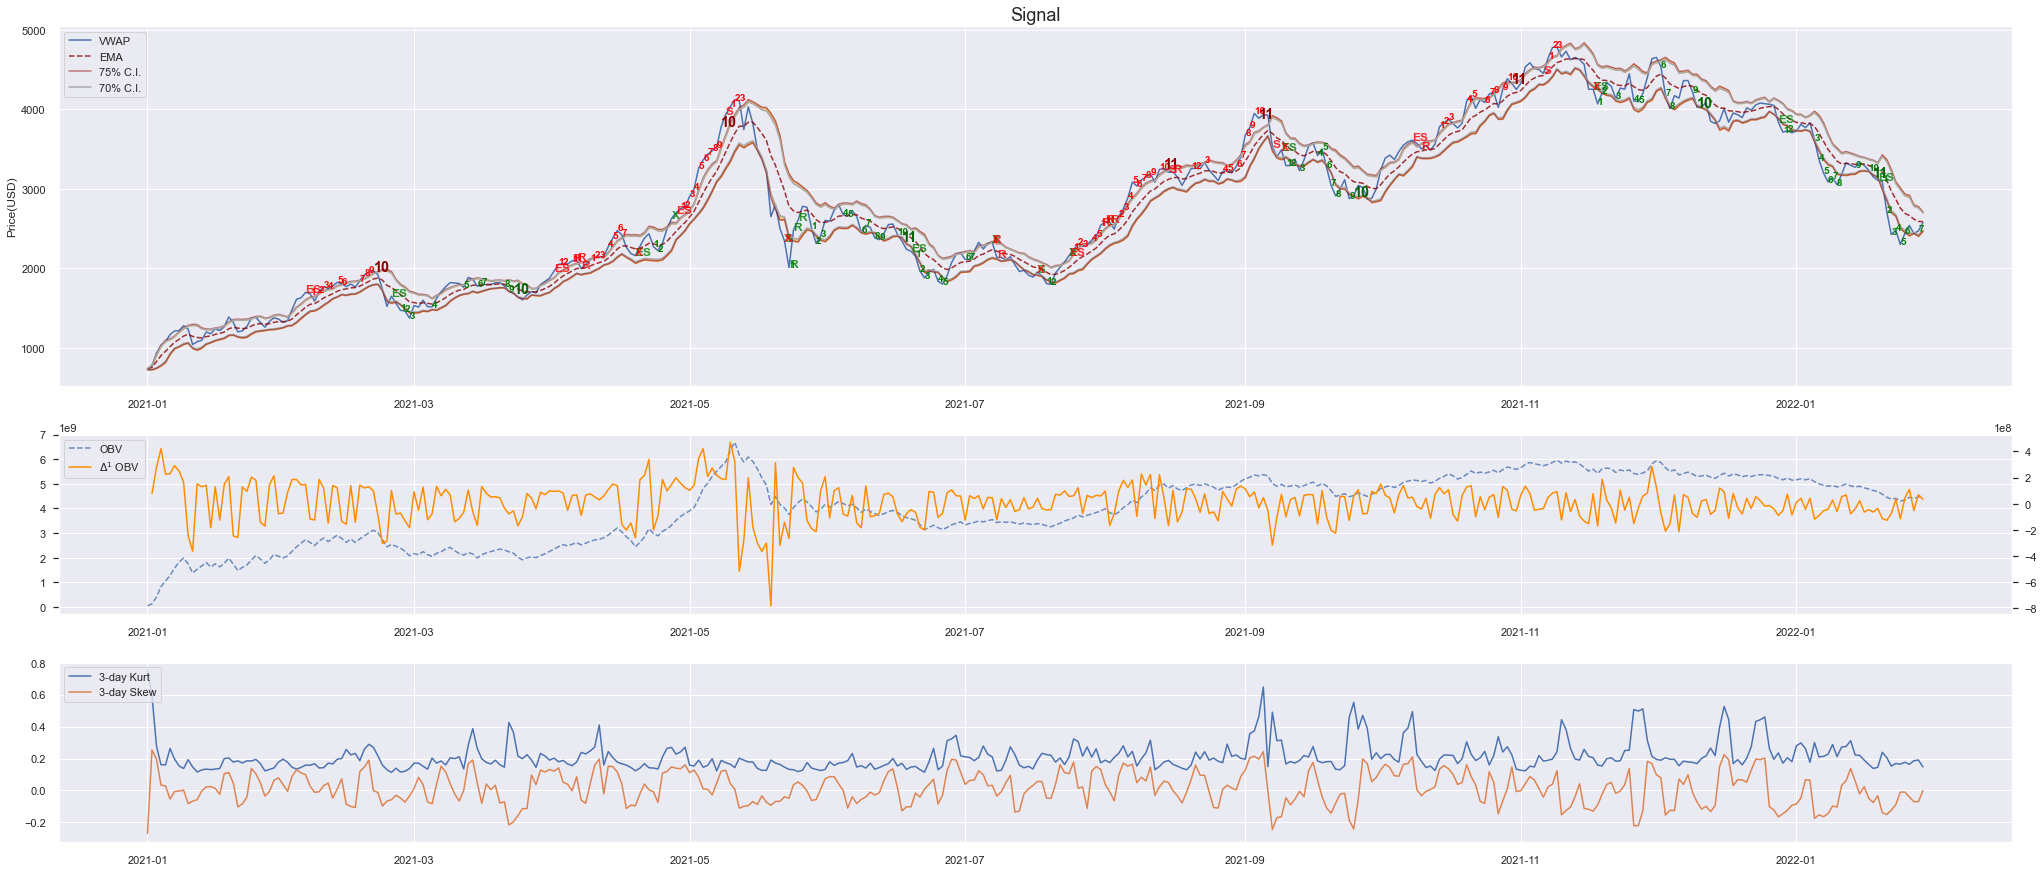

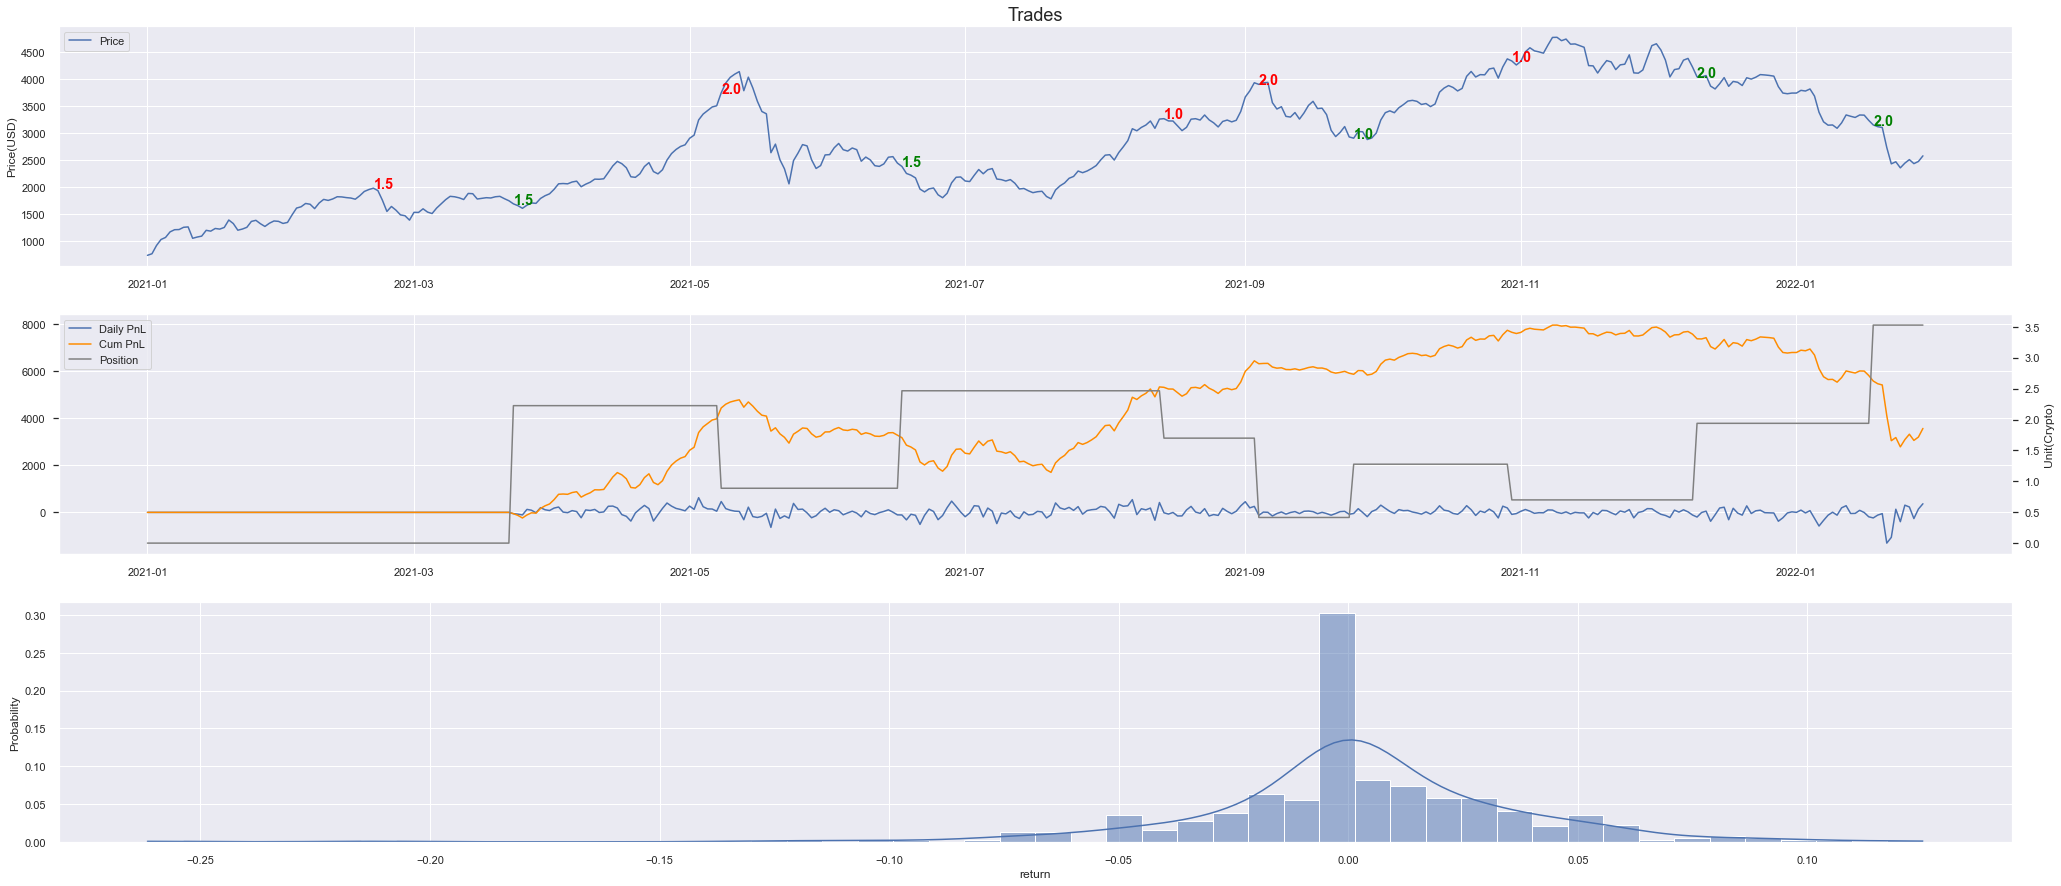

,Max Drawdown($),Downside Beta,Return Mean,Return Std,Return Skew,Return Kurtosis
stats,2967.612893,0.656073,0.001813,0.036282,-1.504194,10.478733


In [67]:
backtesterETH = Backtester(EnhancedDeMark, ticker="eth", start="2021")
backtesterETH.base_backtest()
backtesterETH.plot_signal()
backtesterETH.plot_pnl()

In [142]:
# backtesterETH.optimize()

In [145]:
backtesterETH = Backtester(EnhancedDeMark, ticker="eth", start="2018", end="2020")
backtesterETH.plot_signal()
backtesterETH.plot_pnl()

Getting Live ETH Data...


Generating Signal: 100%|████████████████████| 962/962 [00:15<00:00, 60.20it/s]


In [81]:
# backtesterBTC = Backtester(DeMarkBasedTS, ticker="btc", start="2019")
backtesterETH = Backtester(EnhancedDeMark, ticker="eth", start="2021")

Getting Live ETH Data...


Generating Signal: 100%|██████████████████████| 389/389 [00:06<00:00, 59.12it/s]


In [692]:
sig = backtesterETH.strategy.signal.loc["2021":]
# index = sig[(sig["buy"]!=0)|(sig["sell"]!=0)].index
index = sig.index
sig.loc[index]

,buy,sell,buy setup,sell setup,buy countdown,sell countdown
2021-01-01,0,0,0,0,0,0
2021-01-02,0,0,0,0,0,0
2021-01-03,0,0,0,0,0,0
2021-01-04,0,0,0,0,0,0
2021-01-05,0,0,0,0,0,0
2021-01-06,0,0,0,0,0,0
2021-01-07,0,0,0,0,0,0
2021-01-08,0,0,0,0,0,0
2021-01-09,0,0,0,0,0,0
2021-01-10,0,0,0,0,0,0


In [728]:
rolling_skew = mom["skew"].rolling(7).quantile(0.3).loc[index]
rolling_kurt = mom["kurt"].rolling(7).quantile(0.5).loc[index]

In [729]:
mom = backtesterETH.strategy.bollingbands.signal[["kurt","skew"]].loc["2021":]
# kurt.loc["2020-1":"2021-6"][kurt.loc["2020-1":"2021-6"]<0.1737]
# kurt.loc["2020-1":"2021-6"][kurt.loc["2020-1":"2022-6"] < 0.15]
mom = mom.loc[index]

In [732]:
mom[(mom["skew"] < rolling_skew) & (mom["kurt"]<rolling_kurt)]

,kurt,skew
2021-01-09,0.101216,0.029079
2021-01-11,0.104452,-0.034040
2021-01-12,0.089348,-0.035616
2021-01-21,0.117205,-0.040404
2021-01-22,0.117524,-0.035627
2021-02-05,0.110943,0.055092
2021-02-11,0.104645,-0.028904
2021-02-22,0.117730,-0.088040
2021-02-23,0.129364,-0.050780
2021-02-27,0.101216,-0.051291


In [667]:
# start = "2021-1"
# end = "2022-12"
# backtesterETH.plot_signal(start=start, end=end)
# backtesterETH.plot_pnl(start=start, end=end)

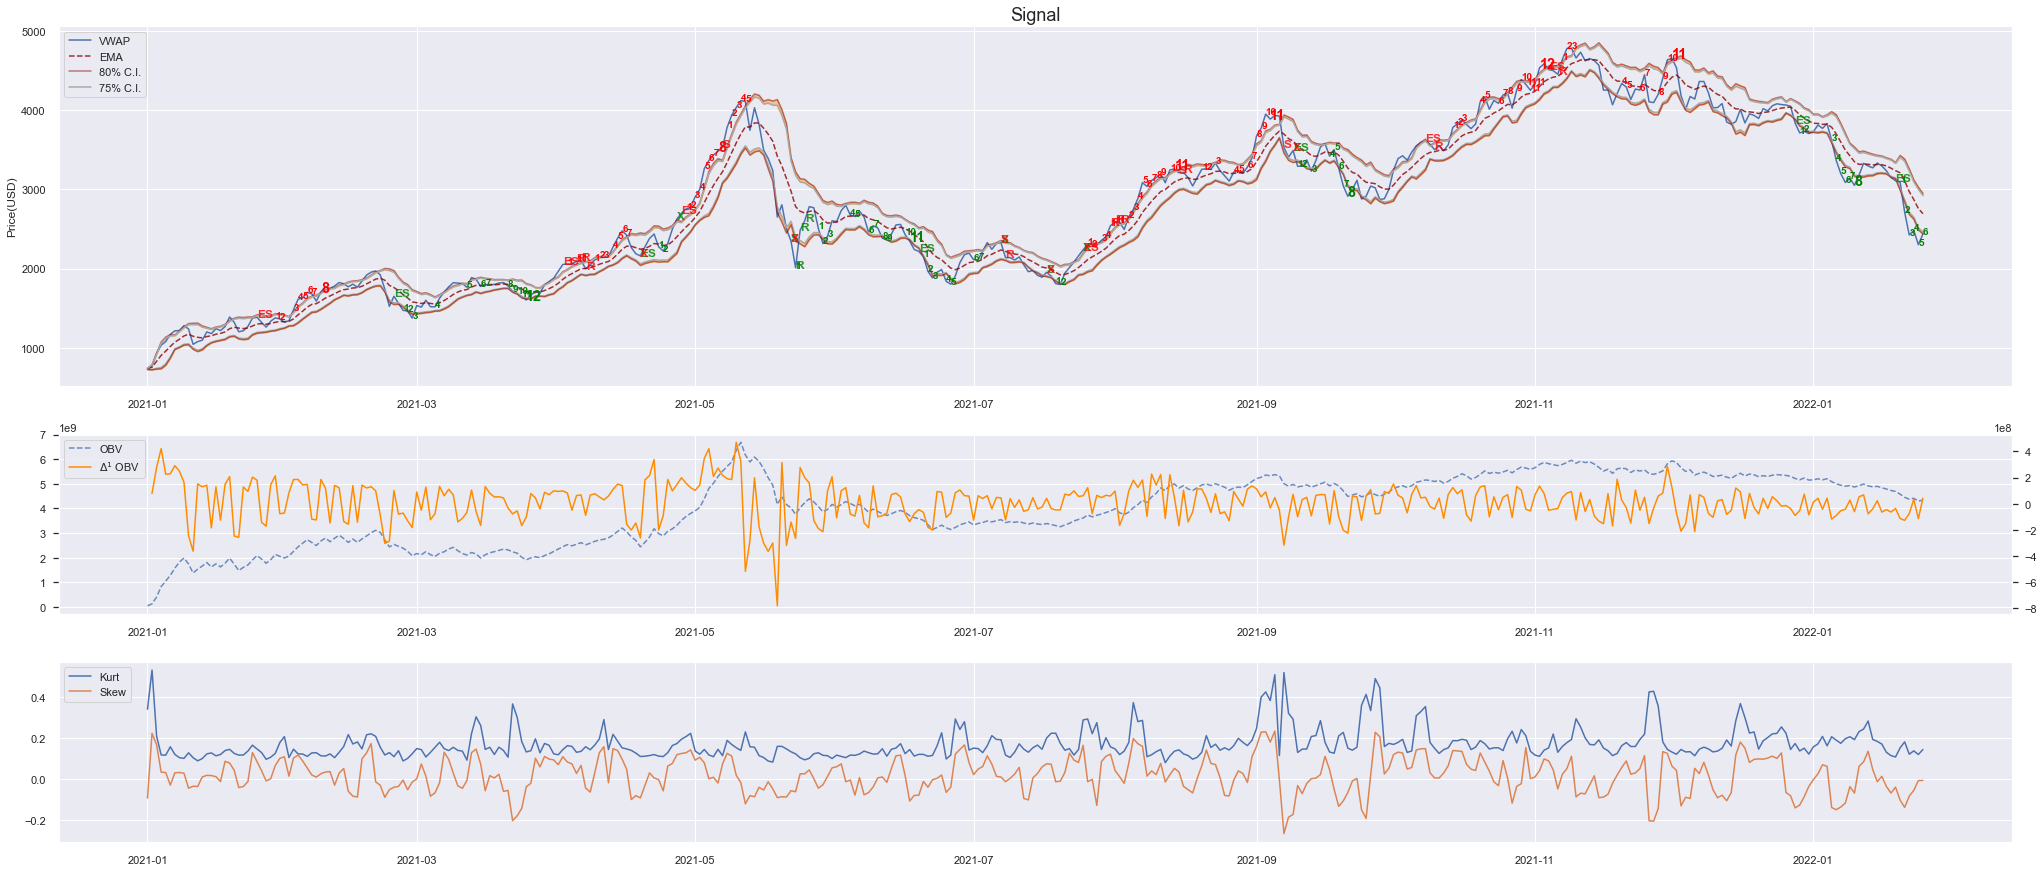

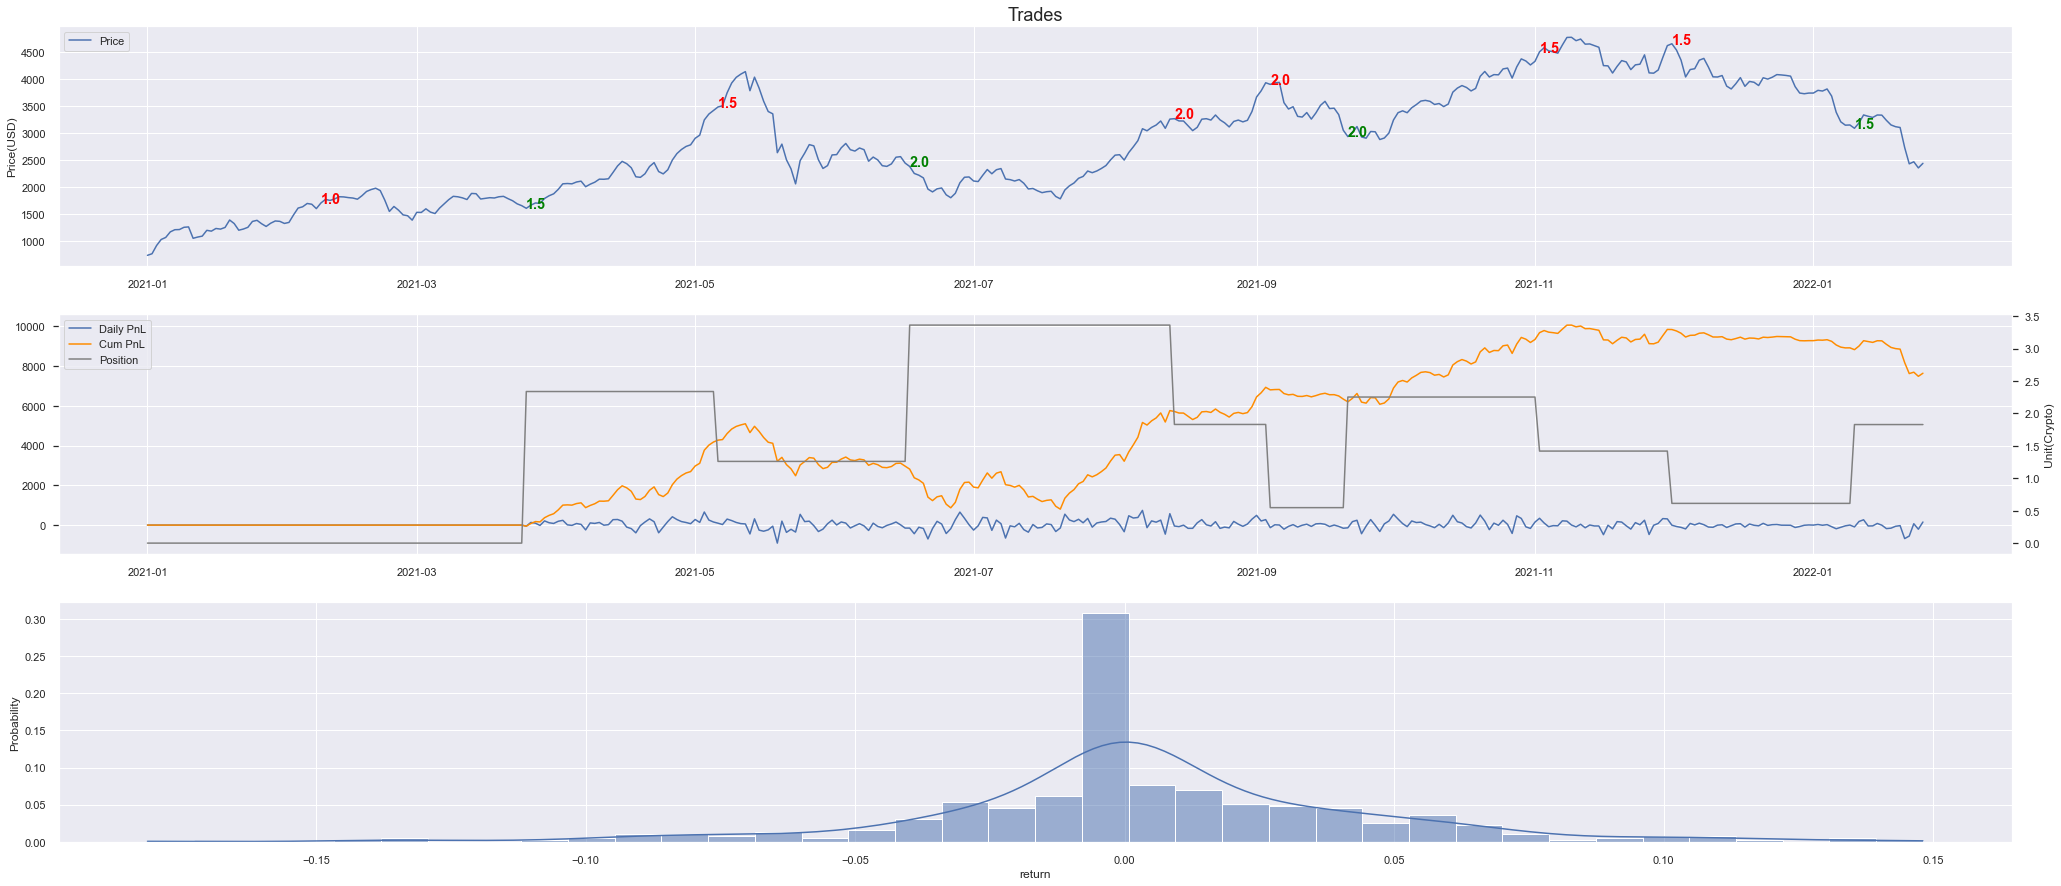

,Max Drawdown($),Downside Beta,Return Mean,Return Std,Return Skew,Return Kurtosis
stats,1885.017881,0.758919,0.003919,0.040177,-0.205129,2.832985


In [582]:
start = "2021"
end = "2022-11"
backtesterETH.plot_signal(start=start, end=end)
backtesterETH.plot_pnl(start=start, end=end)

Getting Live ETH Data...


  0%|          | 0/387 [00:00<?, ?it/s]

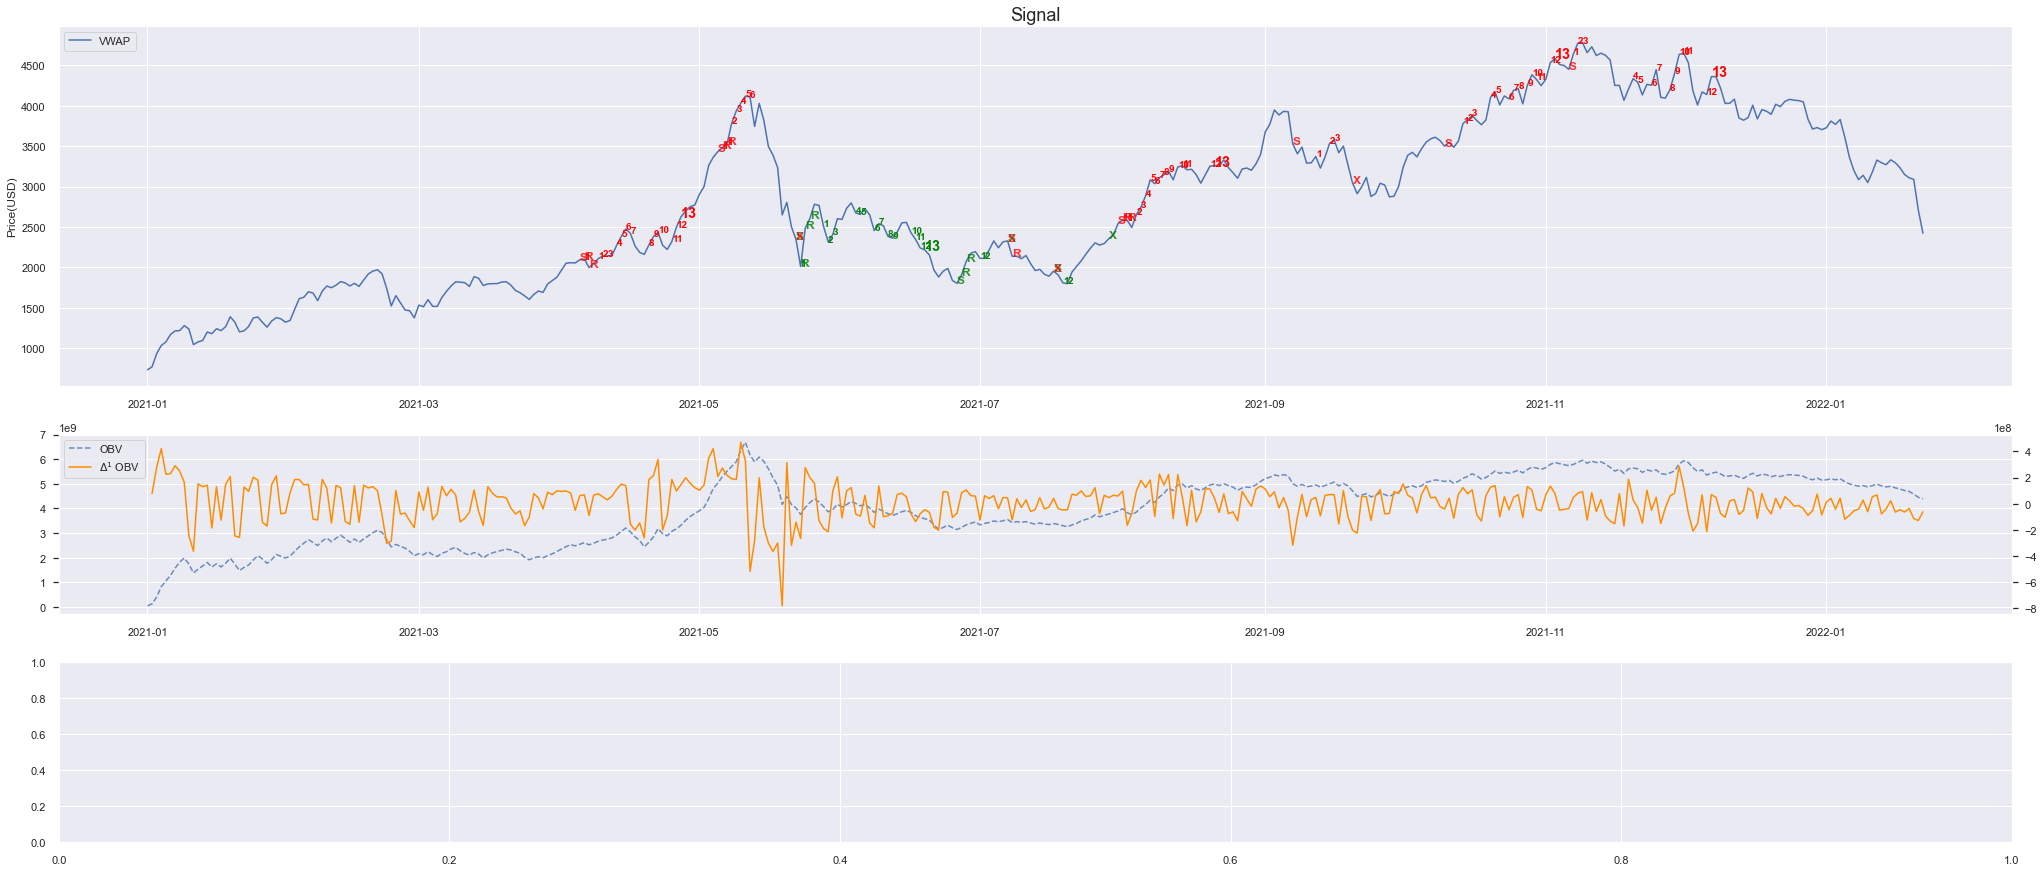

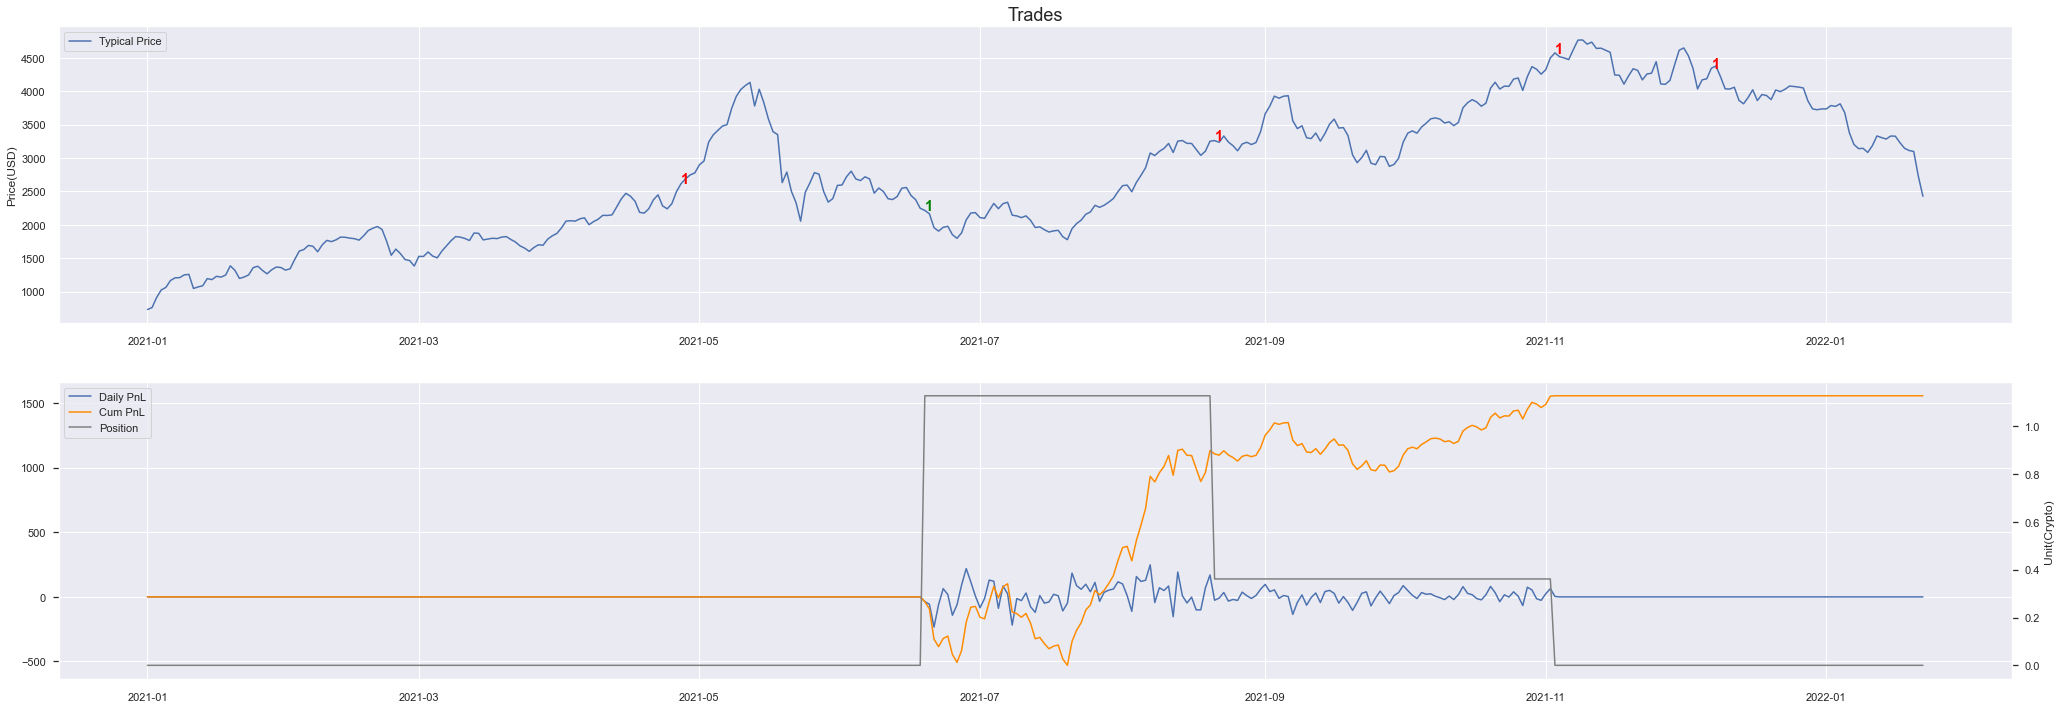

In [670]:
backtesterETH = Backtester(DeMarkSequence, ticker="eth", start="2021")
start = "2020"
end = "2022-11"
backtesterETH.plot_signal(start=start, end=end)
backtesterETH.plot_pnl(start=start, end=end)

In [ ]:
backtesterETH.plot_signal(start="2019-11", end="2020-10")
backtesterETH.plot_pnl(start="2019-11", end="2020-10")

In [ ]:
backtesterBTC.plot_signal(days=252)
backtesterBTC.plot_pnl(days=252)

In [ ]:
backtesterBTC.plot_signal(start="2020-2", end="2020-9")
backtesterBTC.plot_pnl(start="2020-2", end="2020-9")

In [ ]:
backtesterBTC.plot_signal(start="2020-2", end="2021-1")
backtesterBTC.plot_pnl(start="2020-2", end="2021-1")

In [843]:
data = pd.read_json("eth_1h_data")

In [844]:
data = data.loc["2021-1-18":"2021-1-20"]

In [845]:
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data["open"], low=data["low"], high=data["high"], close=data["close"])])

In [ ]:
trades = pd.DataFrame(requests.get('https://api.pro.coinbase.com/products/ETH-USD/trades').json())
trades.head()

In [ ]:
from scipy.integrate import quad

In [238]:
data = backtesterETH.strategy.hourly_data["close"]

In [233]:
def realized_kurt(data):
#     data = np.log(data)
    g = lambda x: min(x, 1-x)
    g2 = lambda x: pow(g(x),2)
    g4 = lambda x: pow(g(x),4)
    g2bar = quad(g2,0,1)[0]
    g4bar = quad(g4,0,1)[0]
    k = 3 
    def f(grid):
        res = 0
        ret = grid.diff(1)
        for i in range(1,len(ret)):
            res += g(i/k)*ret[i]
        return res
    def f_bar(grid):
        res = 0
        ret = grid.diff(1)
        for i in range(1,len(ret)):
            res += ((g(i/k)-g((i-1)/k))*ret[i])**2
        return res
    
    deltaY = data.rolling(window=k).apply(f).dropna()
    deltaYBar = data.rolling(window=k).apply(f_bar).dropna()

    realizedKurt = (deltaY**4).sum() / (k*g4bar)
    realizedVar = ((deltaY**2).sum()/k - deltaYBar.sum()/(2*k))/g2bar
    return realizedKurt / (realizedVar**2)

In [514]:
res = []
for _ in tqdm(range(10)):
    size= 72
    s = pd.Series(data=np.random.normal(2,1.5,size), index=pd.date_range(start="2020-01-01", periods=size))
    res.append(realized_kurt(s))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
np.quantile(res,0.65)

In [239]:
sub = data.loc["2019-1-1":"2021-11-20"]

In [240]:
kurt = sub.resample("1d").apply(realized_kurt)

In [ ]:
# kurt = sub.rolling(window=48).apply(realized_kurt)

In [ ]:
with pd.option_context("display.max_rows", 100000):
    print(kurt)

<AxesSubplot:>

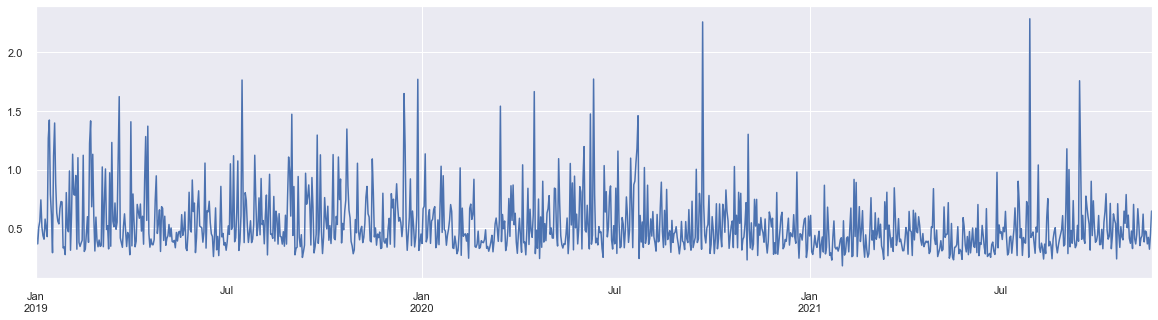

In [241]:
kurt.plot(figsize=(20,5))

In [1007]:
 def TSRV(data, k, j):
    data = np.log(data)
    n = len(data)
    nbarK, nbarJ = (n-k+1)/k, (n-j+1)/j
    adj = (1-(nbarK/nbarJ))**(-1)
    RV_k = np.square(data - data.shift(k)).sum() / k
    RV_j = np.square(data - data.shift(j)).sum() / j
    RV = adj * (RV_k - (nbarK/nbarJ) * RV_j)
    sqrt = np.sqrt(max(0, RV))
    return sqrt

def realized_moments(data, k):
    data = np.log(data)
    g = lambda x: min(x, 1-x)
    g2 = lambda x: pow(g(x),2)
    g3 = lambda x: pow(g(x),2)
    g4 = lambda x: pow(g(x),4)
    g2bar = quad(g2,0,1)[0]
    g3bar = quad(g3,0,1)[0]
    g4bar = quad(g4,0,1)[0]
    def f(grid):
        res = 0
        ret = grid.diff(1)
        for i in range(1,len(ret)):
            res += g(i/k)*ret[i]
        return res
    def f_bar(grid):
        res = 0
        ret = grid.diff(1)
        for i in range(1,len(ret)):
            res += ((g(i/k)-g((i-1)/k))*ret[i])**2
        return res

In [1120]:
params = {"step":60, "limit":300}
r = requests.get(f"https://www.bitstamp.net/api/v2/ohlc/btcusd/", params=params)
data = json.loads(r.text)
data = pd.DataFrame(data['data']['ohlc'])
data.index = [pd.to_datetime(int(t), unit="s")-timedelta(hours=6) for t in data["timestamp"]]
data = data.drop(columns="timestamp")
for c in data.columns:
    data[c] = pd.to_numeric(data[c])
data["Volume USD"] = data["volume"] * data["close"]
data = data.drop(columns=["volume"])
data = data.sort_index(ascending=True)
data

,high,low,close,open,Volume USD
2022-01-29 19:47:00,37931.29,37929.99,37931.29,37929.99,275.760478
2022-01-29 19:48:00,37951.70,37951.70,37951.70,37951.70,216.324690
2022-01-29 19:49:00,37951.70,37951.69,37951.70,37951.69,3014.503531
2022-01-29 19:50:00,37959.81,37959.80,37959.81,37959.81,1275.243494
2022-01-29 19:51:00,37949.22,37940.22,37942.91,37949.22,507.676136
2022-01-29 19:52:00,37946.86,37929.41,37933.57,37946.86,3857.085398
2022-01-29 19:53:00,37947.38,37929.30,37947.38,37929.30,2211.193833
2022-01-29 19:54:00,37949.62,37949.62,37949.62,37949.62,443.251562
2022-01-29 19:55:00,37947.49,37937.02,37937.02,37947.49,1088.792474
2022-01-29 19:56:00,37947.22,37897.24,37908.52,37936.49,111731.974057


In [1107]:
ema = data['close'].ewm(alpha=0.25).mean()

In [1108]:
tsrv = (data["close"].rolling(window=60).apply(TSRV, args=(3,1))/np.sqrt(5))

In [1109]:
# ema * (1+self.big_up_z*std)
up = (1+st.norm.ppf(0.75)*tsrv)*ema
down = (1+st.norm.ppf(0.25)*tsrv)*ema
data["ema"] = ema
data["tsrv"] = tsrv
data["up"] = up
data["down"] = down

In [1110]:

fig = go.Figure(data=[go.Candlestick(x=data.index, open=data["open"], low=data["low"], high=data["high"], close=data["close"]),
                      go.Scatter(x=data.index, y=data["ema"], line=dict(color="blue",dash="dash",width=1)),
                      go.Scatter(x=data.index, y=data["up"], line=dict(color="darkorange",dash="longdash",width=2)),
                      go.Scatter(x=data.index, y=data["down"], line=dict(color="darkorange",dash="longdash",width=2))
                     ])

In [1111]:
data

,high,low,close,open,Volume USD,ema,tsrv,up,down
2022-01-29 19:31:00,37997.63,37997.41,37997.41,37997.63,80.934483,37997.410000,NaN,NaN,NaN
2022-01-29 19:32:00,38000.13,37990.18,38000.13,37990.18,903.263090,37998.964286,NaN,NaN,NaN
2022-01-29 19:33:00,38000.13,37985.66,37985.66,38000.13,3380.730198,37993.211081,NaN,NaN,NaN
2022-01-29 19:34:00,38000.13,38000.13,38000.13,38000.13,767.222625,37995.741429,NaN,NaN,NaN
2022-01-29 19:35:00,37986.57,37966.43,37966.43,37986.57,8181.371953,37986.133585,NaN,NaN,NaN
2022-01-29 19:36:00,37974.13,37944.51,37944.51,37974.13,491.760850,37973.474675,NaN,NaN,NaN
2022-01-29 19:37:00,37950.12,37944.22,37944.22,37946.42,192.031524,37965.034360,NaN,NaN,NaN
2022-01-29 19:38:00,37944.22,37925.00,37944.22,37935.71,643.913413,37959.251868,NaN,NaN,NaN
2022-01-29 19:39:00,37944.22,37944.22,37944.22,37944.22,25.043185,37955.188829,NaN,NaN,NaN
2022-01-29 19:40:00,37944.22,37944.22,37944.22,37944.22,1050.675452,37952.282983,NaN,NaN,NaN


In [1100]:
fig

In [1052]:
data

,high,low,close,open,Volume USD,ema,tsrv,up,down
2022-01-29 14:57:00,38314.26,38290.74,38297.03,38312.79,4455.381111,38297.030000,NaN,NaN,NaN
2022-01-29 14:58:00,38380.57,38325.76,38380.57,38325.76,80109.149277,38344.767143,NaN,NaN,NaN
2022-01-29 14:59:00,38387.21,38376.14,38382.44,38376.14,587.623642,38361.058108,NaN,NaN,NaN
2022-01-29 15:00:00,38384.02,38327.14,38365.79,38375.12,21500.441547,38362.788629,NaN,NaN,NaN
2022-01-29 15:01:00,38374.70,38313.96,38352.80,38374.69,11887.690449,38359.514507,NaN,NaN,NaN
2022-01-29 15:02:00,38400.00,38340.79,38400.00,38350.16,115753.993344,38371.827291,NaN,NaN,NaN
2022-01-29 15:03:00,38472.28,38395.55,38441.79,38400.00,68419.330594,38392.012348,NaN,NaN,NaN
2022-01-29 15:04:00,38650.00,38421.65,38630.85,38424.10,636139.262569,38458.364465,NaN,NaN,NaN
2022-01-29 15:05:00,38741.67,38555.46,38687.04,38630.66,499774.134487,38520.174323,NaN,NaN,NaN
2022-01-29 15:06:00,38654.65,38584.64,38629.35,38640.45,36339.079963,38549.096978,NaN,NaN,NaN


In [1104]:
start = data.index[-1]-timedelta(hours=2)
data.loc[start:]

,high,low,close,open,Volume USD,ema,tsrv,up,down
2022-01-29 22:06:00,37968.51,37952.98,37968.51,37952.98,11237.404737,37965.839478,0.000984,37991.024808,37940.654148
2022-01-29 22:07:00,37966.52,37964.28,37966.52,37964.71,1187.972411,37966.009609,0.000992,37991.420620,37940.598598
2022-01-29 22:08:00,37967.43,37954.91,37958.78,37967.43,2430.380734,37964.202207,0.000990,37989.556028,37938.848385
2022-01-29 22:09:00,37955.72,37955.64,37955.72,37955.64,1319.340827,37962.081655,0.000993,37987.519146,37936.644164
2022-01-29 22:10:00,37959.42,37942.62,37948.12,37959.13,5229.997755,37958.591241,0.001001,37984.214182,37932.968301
2022-01-29 22:11:00,37940.42,37937.08,37940.41,37937.08,900.705333,37954.045931,0.001014,37979.997700,37928.094162
2022-01-29 22:12:00,37940.05,37940.05,37940.05,37940.05,87.641516,37950.546948,0.001034,37977.025774,37924.068123
2022-01-29 22:13:00,37942.62,37940.05,37942.62,37940.05,8570.538955,37948.565211,0.000971,37973.412187,37923.718235
2022-01-29 22:14:00,37939.02,37929.21,37936.63,37939.02,370.640875,37945.581408,0.000964,37970.246164,37920.916653
2022-01-29 22:15:00,37954.93,37923.20,37954.20,37929.20,20092.530291,37947.736056,0.000977,37972.748751,37922.723361


<AxesSubplot:>

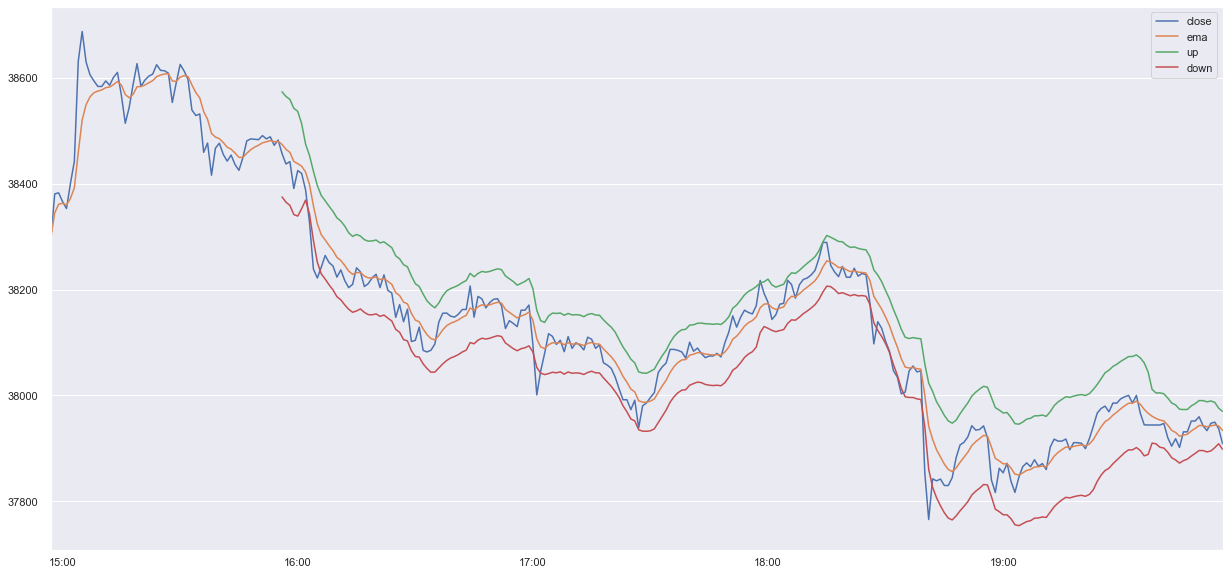

In [1053]:
data[["close","ema","up","down"]].plot(figsize=(21,10))